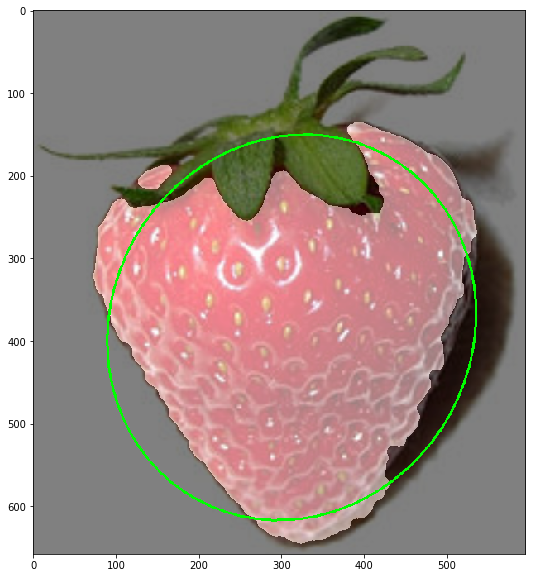

In [6]:
import cv2
from matplotlib import pyplot as plt
import numpy as np


green = (0, 255, 0)

def show(image):
    # Figure size in inches
    plt.figure(figsize=(10, 10))

    # Show image, with nearest neighbour interpolation
    plt.imshow(image, interpolation='nearest')

def overlay_mask(mask, image):
	#make the mask rgb
    rgb_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    #calculates the weightes sum of two arrays. in our case image arrays
    #input, how much to weight each. 
    #optional depth value set to 0 no need
    img = cv2.addWeighted(rgb_mask, 0.5, image, 0.5, 0)
    return img

def find_biggest_contour(image):
    # Copy
    image = image.copy()
    #input, gives all the contours, contour approximation compresses horizontal, 
    #vertical, and diagonal segments and leaves only their end points. For example, 
    #an up-right rectangular contour is encoded with 4 points.
    #Optional output vector, containing information about the image topology. 
    #It has as many elements as the number of contours.
    #we dont need it
    _,contours, _ = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Isolate largest contour
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
    biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]

    mask = np.zeros(image.shape)
    cv2.drawContours(mask, [biggest_contour], -1, 255, -1)
    return biggest_contour, mask

def circle_contour(image, contour):
    # Bounding ellipse
    image_with_ellipse = image.copy()
    #easy function
    ellipse = cv2.fitEllipse(contour)
    #add it
    cv2.ellipse(image_with_ellipse, ellipse, green, 2)
    return image_with_ellipse

def find_strawberry(image):
    #RGB stands for Red Green Blue. Most often, an RGB color is stored 
    #in a structure or unsigned integer with Blue occupying the least 
    #significant “area” (a byte in 32-bit and 24-bit formats), Green the 
    #second least, and Red the third least. BGR is the same, except the 
    #order of areas is reversed. Red occupies the least significant area,
    # Green the second (still), and Blue the third.
    # we'll be manipulating pixels directly
    #most compatible for the transofrmations we're about to do
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Make a consistent size
    #get largest dimension
    max_dimension = max(image.shape)
    #The maximum window size is 700 by 660 pixels. make it fit in that
    scale = 658/max_dimension
    #resize it. same width and hieght none since output is 'image'.
    image = cv2.resize(image, None, fx=scale, fy=scale)
    
    #we want to eliminate noise from our image. clean. smooth colors without
    #dots
    # Blurs an image using a Gaussian filter. input, kernel size, how much to filter, empty)
    image_blur = cv2.GaussianBlur(image, (7, 7), 0)
    #unlike RGB, HSV separates luma, or the image intensity, from
    # chroma or the color information.
    #just want to focus on color, segmentation
    image_blur_hsv = cv2.cvtColor(image_blur, cv2.COLOR_RGB2HSV)

    # Filter by colour
    # 0-10 hue...Standards
    #minimum red amount, max red amount
    min_red = np.array([0, 100, 100])
    max_red = np.array([10, 255, 255])
    #layer
    mask1 = cv2.inRange(image_blur_hsv, min_red, max_red)

    #birghtness of a color is hue
    # 170-180 hue ... Standards 
    min_red2 = np.array([170,100, 100])
    max_red2 = np.array([180, 255, 255])
    mask2 = cv2.inRange(image_blur_hsv, min_red2, max_red2)

    #looking for what is in both ranges
    # Combine masks
    mask = mask1 + mask2

    # Clean up
    #we want to circle our strawberry so we'll circle it with an ellipse
    #with a shape of 15x15
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    #morph the image. closing operation Dilation followed by Erosion. 
    #It is useful in closing small holes inside the foreground objects, 
    #or small black points on the object.
    mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    #erosion followed by dilation. It is useful in removing noise
    mask_clean = cv2.morphologyEx(mask_closed, cv2.MORPH_OPEN, kernel)

    # Find biggest strawberry
    #get back list of segmented strawberries and an outline for the biggest one
    big_strawberry_contour, mask_strawberries = find_biggest_contour(mask_clean)

    # Overlay cleaned mask on image
    # overlay mask on image, strawberry now segmented
    overlay = overlay_mask(mask_clean, image)

    # Circle biggest strawberry
    #circle the biggest one
    circled = circle_contour(overlay, big_strawberry_contour)
    show(circled)
    
    #we're done, convert back to original color scheme
    bgr = cv2.cvtColor(circled, cv2.COLOR_RGB2BGR)
    
    return bgr

#read the image
image = cv2.imread('/home/meracoda/Desktop/berry.jpg')
#detect it
result = find_strawberry(image)